# Jupyter notebook for the curve fitting problem

In [91]:
# import packages
import numpy as np
import matplotlib.pyplot as pp
import pylab
import scipy
import pandas as pd
from scipy.optimize import curve_fit
#from  models_functions import mf_seg, mf_noseg, sir, mf_seg_plot, mf_noseg_plot

%matplotlib inline

In [92]:
# Import data
hoax_data = pd.read_csv('hoaxy_mexico-border-trump-elected_cum.csv',parse_dates=True)
for_users = hoax_data['For']
against_users = hoax_data['Against']
t_empirical=np.arange(0,len(hoax_data))
len_data= len(hoax_data)

# difference data
new_for_users = for_users.diff()[1:for_users.size]
new_against_users = against_users.diff()[1:for_users.size]
new_t_empirical = t_empirical[1:for_users.size]

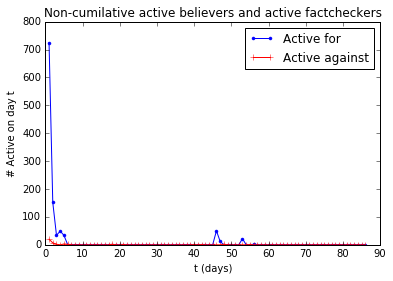

In [93]:
pp.figure()
pp.plot(new_t_empirical, new_for_users, 'b.-',new_t_empirical, new_against_users,'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Non-cumilative active believers and active factcheckers")
pp.legend(['Active for', 'Active against'])
pp.show()

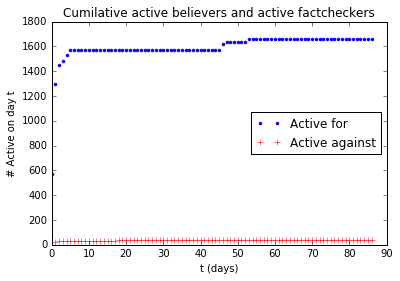

In [94]:
pp.figure()
pp.plot(t_empirical, for_users, 'b.',t_empirical, against_users,'r+')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers and active factcheckers")
pp.legend(['Active for', 'Active against'],loc=5)
pp.show()

# First attempt - fitting with SIR

SIR functions:

In [96]:
def f_SIR(Y, t, beta, mu):

    S = Y[0]
    I = Y[1]
    R = Y[2]

    N = S + I + R

    dS = - beta * I * S / N
    dI = beta * I * S / N - mu * I
    dR = mu * I

    dY = [ dS, dI, dR ]

    return dY

def sir_cum(T, X0, beta, mu, ONEoverN):

    # Initial conditions
    S0 = (1.0-X0)/ONEoverN
    I0 = X0/ONEoverN
    R0 = 0.0

    I = scipy.integrate.odeint(f_SIR,[S0, I0, R0], T, args = (beta, mu))[:,1]

    return (np.cumsum(np.asarray(I)))

First, clean the data a bit - take only the first 30 days

In [97]:
# Firstly, clean the data a bit - take only the n+1 days
n=30
t_empirical_month1 = new_t_empirical[0:n]
for_users_month1 = for_users[0:n]
against_users_month1 = against_users[0:n]
new_for_users_month1 = new_for_users[0:n]
new_against_users_month1 = new_against_users[0:n]

Next, we show (by playing around with some parameters) that the SIR can be a decent fit. First plot is non-cumulative data, second is cumulative

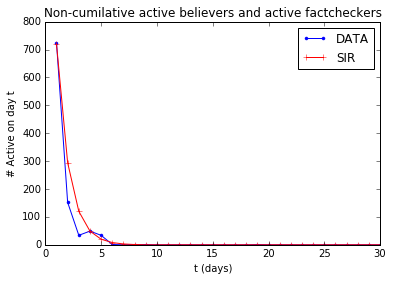

In [98]:
# Play around to see if SIR can possible fit
pp.figure()
pp.plot(t_empirical_month1, new_for_users_month1, 'b.-',
        t_empirical_month1, sir(t_empirical_month1,0.72,0.025,0.9,1000),'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Non-cumilative active believers and active factcheckers")
pp.legend(['DATA', 'SIR'])
pp.show()

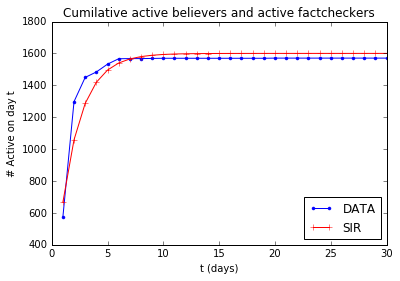

In [107]:
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        sir_cum(t_empirical_month1,0.5,0.25,0.65,0.00075),'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumilative active believers and active factcheckers")
pp.legend(['DATA', 'SIR'],loc=4)
pp.show()

Now, try fitting the SIR model to the cumulative data

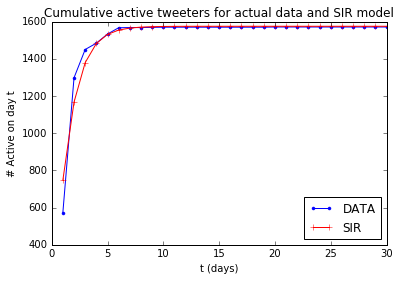

In [111]:
# Initial parameter estimates and bounds for parameters
param0 =[0.5,0.5,0.5,0.5]
param_bounds =([0, 0, 0, 0], [1., 1., 1., 1.])

# Curve fit
popt, cov = curve_fit(sir_cum, t_empirical_month1,for_users_month1,p0=param0,bounds=param_bounds)

# Output
pp.figure()
pp.plot(t_empirical_month1, for_users_month1, 'b.-',t_empirical_month1, 
        sir_cum(t_empirical_month1,*popt),'r+-')
pp.xlabel("t (days)")
pp.ylabel("# Active on day t")
pp.title("Cumulative active tweeters for actual data and SIR model")
pp.legend(['DATA', 'SIR'],loc=4)
pp.show()
pp.savefig('hoaxy_mexico_SIRfit.pdf', format='pdf')
